In [1]:
!pwd

/ssl-jet-vol/semi-supervised-tests/Jupyter


In [2]:
import math
import os.path as osp

import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask

import sys
sys.path.insert(0, '..')  #go up one directory
from src.data.jetnet_graph import JetNetGraph
from custom_libraries.my_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
root = "/ssl-jet-vol/semi-supervised-tests/Jupyter"
dataset = JetNetGraph(root, max_jets=3_000, n_files=1)  # just use one file, 1k jets for fast testing

class UniMP(torch.nn.Module):
    def __init__(self, in_channels, num_classes, hidden_channels, num_layers, heads, dropout=0.3):
        super().__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.label_emb = MaskLabel(self.num_classes, self.in_channels)
        self.hidden_channels = hidden_channels

        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_channels = self.hidden_channels // heads
                concat = True
            else:
                out_channels = self.num_classes
                concat = False
            conv = TransformerConv(in_channels, out_channels, heads, concat=concat, beta=True, dropout=dropout)
            self.convs.append(conv)
            in_channels = self.hidden_channels

            if i < num_layers:
                self.norms.append(torch.nn.LayerNorm(self.hidden_channels))

    def forward(self, x, y, edge_index, label_mask):
        x = self.label_emb(x, y, label_mask)
        for conv, norm in zip(self.convs, self.norms):
            x = norm(conv(x, edge_index)).relu()
        return self.convs[-1](x, edge_index)

Loading QG_jets_withbc_0.npz


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = dataset.data.to(device)

model = UniMP(in_channels=dataset.num_features, num_classes=5, hidden_channels=64, num_layers=3, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

tv_frac = 0.10
tv_num = math.ceil(data.num_nodes * tv_frac)  # round to nearest integer
splits = np.cumsum([data.num_nodes - 2 * tv_num, tv_num, tv_num])

train_index = torch.tensor(np.arange(start=0, stop=splits[0]), dtype=torch.long)
val_index = torch.tensor(np.arange(start=splits[0], stop=splits[1]), dtype=torch.long)
test_index = torch.tensor(np.arange(start=splits[1], stop=data.num_nodes), dtype=torch.long)

train_mask = index_to_mask(train_index, size=data.num_nodes)
val_mask = index_to_mask(val_index, size=data.num_nodes)
test_mask = index_to_mask(test_index, size=data.num_nodes)

In [5]:
splits

array([33892, 38129, 42366])

In [6]:
[data.num_nodes - 2 * tv_num, tv_num, tv_num]

[33892, 4237, 4237]

In [7]:
def train(label_rate=0.75):  # How many labels to use for propagation
    model.train()

    propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
    supervision_mask = train_mask ^ propagation_mask

    optimizer.zero_grad()
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    loss = F.cross_entropy(out[supervision_mask], data.y[supervision_mask])
    loss.backward()
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()

    propagation_mask = train_mask
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[val_mask].argmax(dim=-1)
    val_acc = int((pred == data.y[val_mask]).sum()) / pred.size(0)

    propagation_mask = train_mask | val_mask
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[test_mask].argmax(dim=-1)
    test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)

    return val_acc, test_acc

In [16]:
def reset_params(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()
reset_params(model)

In [17]:
reset_params(model)

label_rate = 0.75
num_epochs = 100
loss_lst, val_acc_lst, test_acc_lst = [], [], []
for epoch in range(1, num_epochs+1):
    loss = train(label_rate=label_rate)
    val_acc, test_acc = test()
    print(f"Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
    loss_lst.append(loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

Epoch: 001, Train Loss: 0.8433, Val Acc: 0.5749, Test Acc: 0.5733
Epoch: 002, Train Loss: 0.8385, Val Acc: 0.5768, Test Acc: 0.5742
Epoch: 003, Train Loss: 0.8407, Val Acc: 0.5747, Test Acc: 0.5782
Epoch: 004, Train Loss: 0.8460, Val Acc: 0.5761, Test Acc: 0.5782
Epoch: 005, Train Loss: 0.8469, Val Acc: 0.5754, Test Acc: 0.5782
Epoch: 006, Train Loss: 0.8457, Val Acc: 0.5761, Test Acc: 0.5787
Epoch: 007, Train Loss: 0.8457, Val Acc: 0.5768, Test Acc: 0.5735
Epoch: 008, Train Loss: 0.8408, Val Acc: 0.5740, Test Acc: 0.5705
Epoch: 009, Train Loss: 0.8500, Val Acc: 0.5752, Test Acc: 0.5721
Epoch: 010, Train Loss: 0.8558, Val Acc: 0.5773, Test Acc: 0.5754
Epoch: 011, Train Loss: 0.8459, Val Acc: 0.5771, Test Acc: 0.5778
Epoch: 012, Train Loss: 0.8512, Val Acc: 0.5745, Test Acc: 0.5780
Epoch: 013, Train Loss: 0.8524, Val Acc: 0.5768, Test Acc: 0.5771
Epoch: 014, Train Loss: 0.8414, Val Acc: 0.5761, Test Acc: 0.5775
Epoch: 015, Train Loss: 0.8540, Val Acc: 0.5771, Test Acc: 0.5773
Epoch: 016

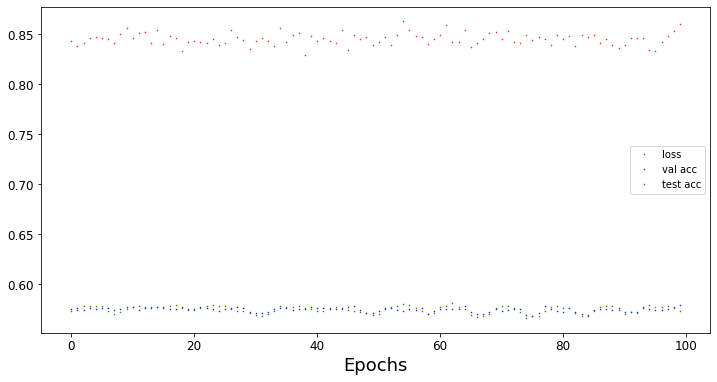

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
marker_size = 1
plt.plot(loss_lst, "r.", markersize=marker_size, label="loss")
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

### Obtain predicted probabilities

In [21]:
propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
out = model(data.x, data.y, data.edge_index, propagation_mask)
pred = out[test_mask].argmax(dim=-1)
m = torch.nn.Softmax(dim=1)
out_norm = m(out)  # the predicted probabilities

In [23]:
out_norm.size()

torch.Size([42366, 5])

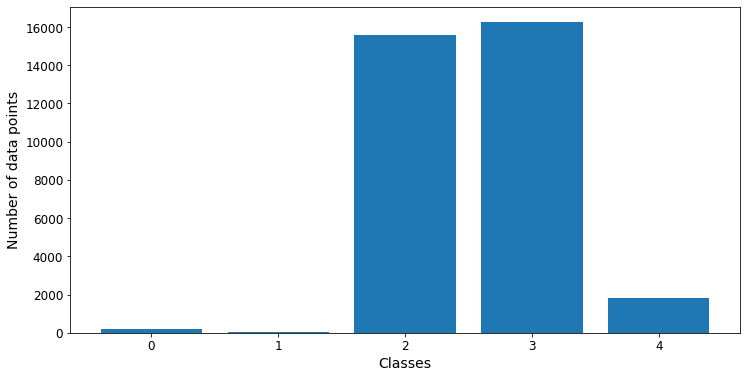

In [24]:
classes = np.array([i for i in range(5)])
labels_arr = data.y[train_mask].cpu().numpy()
class_dict = plot_class_balance(classes, labels_arr)

{0: [30, 0], 1: [2, 0], 2: [1891, 1077], 3: [2070, 1354], 4: [244, 0]}


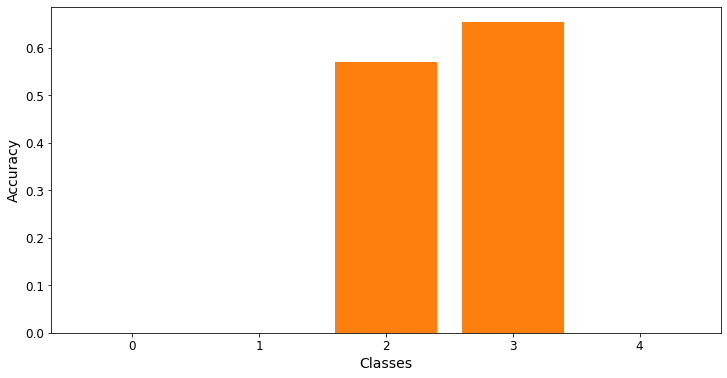

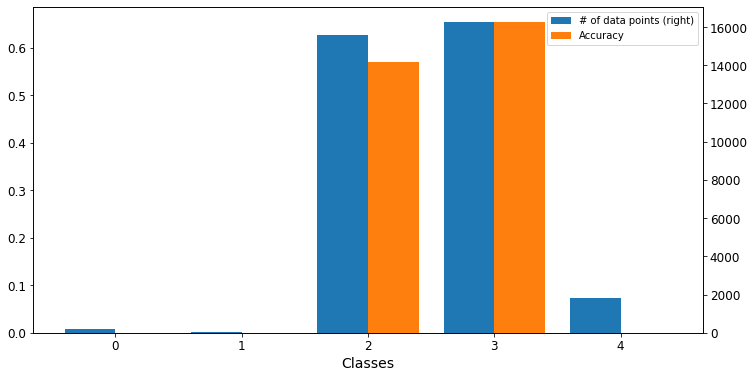

In [25]:
labels_arr = data.y[test_mask].cpu().numpy()
plot_class_balance_and_accuracy(class_dict, labels_arr, pred)

0.6410981697171381
0.78913813459268
0.6662423252242979
0.6331593355760207
0.6626155197825703


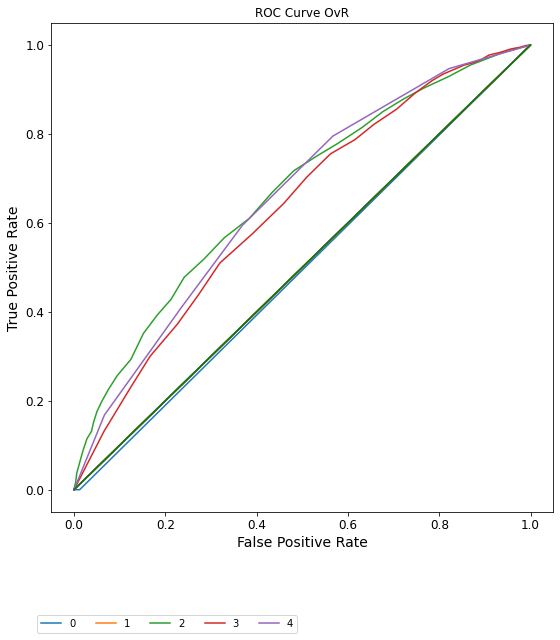

In [26]:
roc_auc_ovr = plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], ncol=5)

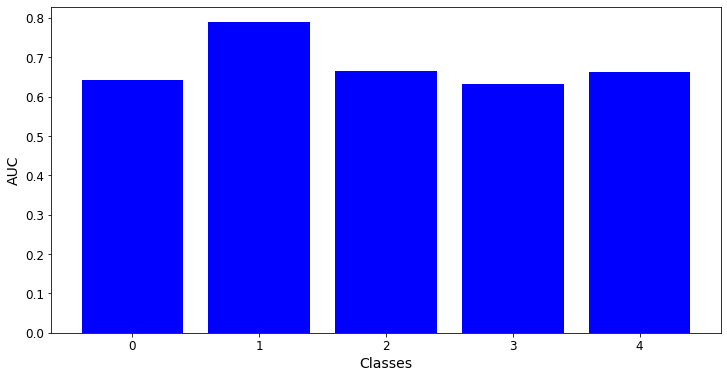

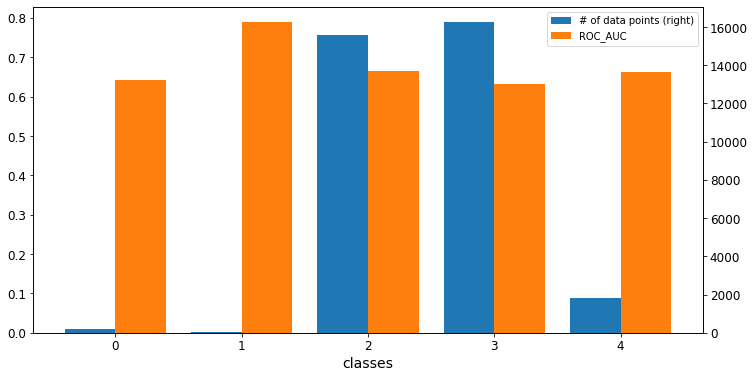

In [27]:
plot_class_balance_and_AUC(class_dict, roc_auc_ovr)